# Introduction

In this exercise, we want to extend on the abilites of the U-Net of the last exercise and create a Generative Adversarial Network. First we will apply it to a more complex segmentation task, while the U-Net is certainly suited to this task it can be improved by using GAN approaches for selfsupervision. Furthermore, the final GAN should be able to invert the task and recreate original images from the segmented images. Since the training of a GAN usually takes a while we will not achive realistic images but the structures and certain details should generate and be recognizable.

We will

1. Modify the Datapipe for a new Dataset

2. Extend the Model to create a GAN

3. Improving the Discriminator

4. Generate Images

For results the different Networks should be running and the Output of the Last Network (Section 4.) Should be submitted for after at least 20 Epochs. Any Question should be answered in as few sentences or bulletpoints as possible.

# 0. Prequisites

We will first import the necessary data. Please, before running the following code, access the link below, right click on the .zip file, then click "Add shortcut to Drive" and select your Drive folder:

https://drive.google.com/file/d/1BLMs1klSrIgZ48arCKYxpn0jTCrV3Hg6/view?usp=sharing

Like always:
Make sure to request GPUs from Colab.
Make a copy to allow saving.

In [1]:
#from google.colab import drive
# mount drive
#drive.mount('/content/drive')

#!unzip -qq '/content/drive/MyDrive/data/CMP_facade_DB.zip'

In [ ]:
%cd content/CMP_facade_DB/

This will handle all the imports we will need for this Notebook

In [2]:
import torch
import os
import random

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as TF

from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models.mobilenetv2 import InvertedResidual

from utils.SegmentationModel import SegmentationModel

import matplotlib.pyplot as plt

# 1. Modify the Datapipe for a new Dataset

This time we are going to work with the segmentation of facades. A good first step is always to download the data and look into it. The folder structure should be the same as in the last exercise but some things will be different and we will need to modify the CustomDataset Class to make it work for our new Data.

1. The Masks have a different file type
2. The Images are neither of the same size nor do they have a constant aspect ratio
  - The images are a bit too detailed for the time we have for training so in a first step we want to half the size of the image
  -  We already have a random crop function we can use. But now not all images are at a minimum 256x256. So we have to change the function so that it will work with smaller inputs. Consider that the output size still needs to be 256x256! (Feel free to look up the code of the original *get_crop_param *function that we used)
3. We do not need nor want the same data augmentation.
  - In this usecase we will reduce most of the preprocessing and only apply the randomcrop and a horizontal flip.
  - Of course more preprocessing steps could be useful but some might not make sense with the data we were given. Why would we want or not want to apply: **Random rotation, Vertical flipping, Color Jitter, Gaussian Blur and Grayscale**?

*Optional: Resize the images by half or even to a quarter of the original size to make the training faster. (Recommended for testing and faster results)*




***Answer Questions here***

We should not use Colour Jitter because House facades are commonly not very colourful. The GAN should create images that are close to the real world.
Random rotation also creates images that are not close to reality since Houses are ususally not upside down, same with Vertical flipping.

Gaussian Blur and Grayscale however could add usefull variation since house facades are black, gray and white often, and a blur could increase the robustness. 


In [3]:
class CustomDataset(Dataset):
    def __init__(
        self, root_dir, transform, transform_mask, flip_target_and_input = False):
        self.root_dir = root_dir
        self.transform = transform
        self.transform_mask = transform_mask
        self.flip = flip_target_and_input
        self.img_dir = os.path.join(root_dir, "rgb")
        self.mask_dir = os.path.join(root_dir, "segmentation")
        self.img_filenames = sorted(os.listdir(self.img_dir))


    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_filename = self.img_filenames[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        
        mask_filename = os.path.splitext(img_filename)[0] + ".png"
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        image, mask = self.common_transform(image, mask)

        image = self.transform(image)
        mask = self.transform_mask(mask)

        return image, mask

    def get_crop_param(self, img, output_size):
        width, height = img.size
        if width < output_size or height < output_size:
            if width < height:
                new_width = output_size
                new_height = int(height * (output_size / width))
                return new_width, new_height
            else:
                new_width = int(width * (output_size / height))
                new_height = output_size
                return new_width, new_height
        return -1, -1


    def common_transform(self, image, mask):
        #print(image.size)
        resize_transform = transforms.Resize((image.size[1] // 2, image.size[0] // 2))
        image = resize_transform(image)
        mask = resize_transform(mask)
        # print(image.size)
        # Random crop
        new_width, new_height = self.get_crop_param(image, 256)

        if new_width != -1:
            resize_transform = transforms.Resize((new_width, new_height))
            image = resize_transform(image)
            mask = resize_transform(mask)
            #print(image.size)
        
        crop_size = 256
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_size, crop_size))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        #print(image.size)
        # # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        #Optional: More resizing
        if self.flip:
            return mask, image
        return image, mask

In [4]:
# Define the paths to your train and test data folders
train_data_path = "train_data"
test_data_path = "test_data"

# Define the transformations to be applied to the images and masks
transform_img = transforms.Compose(
    [
        transforms.CenterCrop(256), #Optional: Change if you are resizing the images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

transform_mask = transforms.Compose(
    [
        transforms.CenterCrop(256), #Optional: Change if you are resizing the images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

# Create the training dataset
train_dataset = CustomDataset(
    root_dir=train_data_path,
    transform=transform_img,
    transform_mask=transform_mask
)

# Create the testing dataset
test_dataset = CustomDataset(
    root_dir=test_data_path,
    transform=transform_img,
    transform_mask=transform_mask
)

# Define the batch size for the DataLoader
batch_size = 16

# Create the testing data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This is a basic training loop that should work for the U-NET. Add the output function to check if your random crop and resize works and Run the U-NET with the new Data. The results should look like a "blobby" segmentations with mainly blue and red coloring. We do not need to train the network for long since a full training would take far too much time so we should not expect the results to be precice at this point.

In [5]:
import torchvision.utils as vutils

def plot_batch(batch_images, batch_masks):
    grid_images = vutils.make_grid(batch_images, nrow=4, padding=10, normalize=True)
    grid_masks = vutils.make_grid(batch_masks, nrow=4, padding=10, normalize=True)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].imshow(grid_images.permute(1, 2, 0))
    axes[0].set_title("Images")
    axes[0].axis("off")

    axes[1].imshow(grid_masks.permute(1, 2, 0))
    axes[1].set_title("Masks")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
output_interval = 3
learning_rate = 0.0002
num_epochs = 12

random.seed(42)
torch.manual_seed(42)

# Create an instance of the UNet
gen_model = SegmentationModel(3)

# Define loss functions
criterion = nn.L1Loss()

# Define optimizers for generator and discriminator
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate)

# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cuda:2')
gen_model.to(device)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    total_l1 = 0.0
    num_samples = 0

    gen_model.train()  # Set the model to training mode

    # Initialize the progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=80)

    for img, mask in pbar:
        # Move the data to the appropriate device
        img = img.to(device)
        mask = mask.squeeze(1).to(device)
        #plot_batch(img.cpu(), mask.cpu())
        #### -------------- ####
        #    Generator step    #
        #### -------------- ####

        # Set generator gradients to zero
        gen_optimizer.zero_grad()
        # Forward pass
        output = gen_model(img)
        # Compute losses
        gen_loss = criterion(output, mask)
        loss = gen_loss

        # Backward pass and optimization step
        loss.backward()
        gen_optimizer.step()

        # Update the progress bar description with the current loss
        pbar.set_postfix({"Loss": loss.item()})
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss}")

    # Validation loop
    gen_model.eval()  # Set the model to evaluation mode
    iteration = 0  # Initialize the iteration counter
    with torch.no_grad():
        for val_img, val_mask in test_loader:
            val_img = val_img.to(device)
            val_mask = val_mask.squeeze(1).to(device)
            val_output = gen_model(val_img)
            val_loss += criterion(val_output, val_mask).item()

            if (epoch + 1) % output_interval == 0 and iteration == 0:
                plot_batch(val_img.cpu(), val_output.cpu())

            iteration += 1

        # update validation loss
        val_loss /= len(test_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {val_loss}")

# 2. Extend the Model to create a GAN

GANs introduce a second Network, the discriminator to enable additional supervision in the trainings process. The discriminators' task is to decide if a given image is a real image or generated. it will be trained by its success on that task while the original Network will get feedback if and how easy this task was.

In our case the U-Net is the generator now we are missing the discriminator. At a first step we implement a simple discriminator Network. Four layers of both **Convolution** and **LeakyReLU** and a **Linear layer** outputting onto one Class. Add an **InstanceNorm2d** layer directly after the first Convolution layer.

In [6]:
class simpleDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(simpleDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            *discriminator_block(512, 1024),
        )

        # The height and width of downsampled image
        ds_size = 256 // (2 ** 5)

        self.out_layer = nn.Sequential(
            nn.Linear(1024 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img_input):
        x = self.model(img_input)
        # Flattens the output to one per image in batch
        return self.out_layer(x.view(x.shape[0], -1))

We can adjust the training loop from the last exercise by adding the new losses and the new Network.
 1. The discriminator has to be included added to the trainings loop so it can be trained
 2. The gan_criterion has be be added to the Generator step.
 	- Since the losses are of different magnitude, weights have to be added. **Weight the existing l1Loss 100 times the gan Loss**
 3. Add the training for the Discriminator in the Discriminator step

 Run the GAN now. The Network should quickly manage to color the image mainly in blue background and add some light blue, red, and green segmentation to many objects in the Image. Again we do not need to train the network for long time just for a few outputs to be created.

In [ ]:
output_interval = 3
learning_rate = 0.0002
num_epochs = 12

random.seed(42)
torch.manual_seed(42)

# Create an instance of the Networks
gen_model = SegmentationModel(3)
dis_model = simpleDiscriminator(3)

# Define loss functions
criterion = nn.L1Loss()
gan_criterion = nn.BCEWithLogitsLoss()

# Define optimizers for generator and discriminator
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate)
dis_optimizer = optim.Adam(dis_model.parameters(), lr=learning_rate)

# Move the models to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cuda:3')

gen_model.to(device)
dis_model.to(device)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    total_l1 = 0.0
    num_samples = 0

    # Set the models to training mode
    gen_model.train()
    dis_model.train()

    # Initialize the progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=80)

    for img, mask in pbar:
        # Move the data to the appropriate device
        img = img.to(device)
        mask = mask.squeeze(1).to(device)

        # Define ground truths for the GAN
        valid = torch.ones((img.shape[0], 1), dtype=img.dtype, device=img.device, requires_grad=False)
        fake = torch.zeros((img.shape[0], 1), dtype=img.dtype, device=img.device, requires_grad=False)

        #### -------------- ####
        #    Generator step    #
        #### -------------- ####

        # Set generator gradients to zero
        gen_optimizer.zero_grad()
        # Forward pass
        output = gen_model(img)
        # Compute losses
        gen_loss = criterion(output, mask)
        gan_loss = gan_criterion(dis_model(output), valid)
        loss = gan_loss + 100 * gen_loss

        # Backward pass and optimization step
        loss.backward()
        gen_optimizer.step()

        # Update the progress bar description with the current loss
        pbar.set_postfix({"Loss": loss.item()})
        train_loss += loss.item()

        #### ------------------ ####
        #    Discriminator step    #
        #### ------------------ ####

        
        dis_optimizer.zero_grad()
        
        real_loss = gan_criterion(dis_model(mask), valid)
        
        fake_loss = gan_criterion(dis_model(output.detach()), fake)
        
        dis_loss = 0.5 * (real_loss + fake_loss)

        dis_loss.backward()
        dis_optimizer.step()

    train_loss /= len(train_loader)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss}")

    # Validation loop
    gen_model.eval()  # Set the generator model to evaluation mode
    dis_model.eval()  # Set the discriminator model to evaluation mode
    iteration = 0  # Initialize the iteration counter
    with torch.no_grad():
        for val_img, val_mask in test_loader:
            val_img = val_img.to(device)
            val_mask = val_mask.squeeze(1).to(device)
            val_output = gen_model(val_img)
            val_loss += criterion(val_output, val_mask).item()

            if (epoch + 1) % output_interval == 0 and iteration == 0:
                plot_batch(val_img.cpu(), val_output.cpu())

            iteration += 1

        # update validation loss
        val_loss /= len(test_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {val_loss}")


#3. Improving the Discriminator

So far the Discriminator is only looking at the image as a whole. A common approach to improve this is to use PatchGAN. For a transformation of an image A to B, in our case Image to Segmentation Mask, it will do two things:

1. It will look at patches instead of the whole image. For this task we create another Discriminator, which instead of the last conv and linear layer has a **ZeroPad2d** and a **Conv2d** Layer. Removing the last Conv-Layer will result in a 32x32 image, the padding layer should pad zeroes on the left and the top. The last Conv layer should result in 30x30 matrix where each value represents the result of a patch.  

2. it will use two images as input and will compare Image A to target B and Image A to generated A, the generator's task is to reduce the difference between those two comparisons while the discriminator's task is to increase the difference between them.

*Hint: Despite these changes the code of the discriminator does not need to change a lot.*

Furthermore we change the Crossentropy criterion to nn.MSELoss(). Why is that?




***Answer Questions here***



When using patchGAN, we do not need to assess the joint statistics of the result, thus, MSE is enough.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False),
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
output_interval = 3
learning_rate = 0.0002
num_epochs = 18

random.seed(42)
torch.manual_seed(42)

# Create an instance of the UNet
gen_model = SegmentationModel(3)
dis_model = Discriminator(3)

# get output shape of image discriminator (PatchGAN)
patch = (256 // 2 ** 4, 256 // 2 ** 4) #Optional: If you changed the size of the input image you will need to change the values here

# Define loss functions
criterion = nn.L1Loss()
gan_criterion = nn.MSELoss()

# Define optimizers for generator and discriminator
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate)
dis_optimizer = optim.Adam(dis_model.parameters(), lr=learning_rate)

# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cuda:3')
gen_model.to(device)
dis_model.to(device)

# Training loop
for epoch in range(num_epochs):
    gen_train_loss = 0.0
    dis_train_loss = 0.0
    gen_val_loss = 0.0
    dis_val_loss = 0.0
    num_samples = 0

    # Set the models to training mode
    gen_model.train()
    dis_model.train()

    # Initialize the progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=80)

    for img, mask in pbar:
        # Move the data to the appropriate device
        img = img.to(device)
        mask = mask.squeeze(1).to(device)

        # Define ground truths for the GAN
        # Hint: you will need the patch variable
        valid = torch.ones((img.size(0), *patch), device=device, requires_grad=False)
        fake = torch.zeros((img.size(0), *patch), device=device, requires_grad=False)


        #### -------------- ####
        #    Generator step    #
        #### -------------- ####

        # Set generator gradients to zero
        gen_optimizer.zero_grad()

        output = gen_model(img)
        dis_output = dis_model(output, img)

        gen_loss = criterion(output, mask)
        gan_loss = gan_criterion(dis_output, valid)
        loss = gan_loss + 100 * gen_loss

        # Backward pass and optimization step
        loss.backward()
        gen_optimizer.step()

        # Update the progress bar description with the current loss
        pbar.set_postfix({"Loss": loss.item()})
        gen_train_loss += loss.item()

        #### ------------------ ####
        #    Discriminator step    #
        #### ------------------ ####

        dis_optimizer.zero_grad()

        real_pred = dis_model(mask, img)
        real_loss = gan_criterion(real_pred, valid)

        fake_pred = dis_model(output.detach(), img)
        fake_loss = gan_criterion(fake_pred, fake)


        dis_loss = 0.5 * (real_loss + fake_loss)

        dis_loss.backward()

        dis_optimizer.step()

        dis_train_loss += dis_loss.item()

    gen_train_loss /= len(train_loader)
    dis_train_loss /= len(train_loader)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Generator Training Loss: {gen_train_loss} | Discriminator Training Loss: {dis_train_loss}")

    # Validation loop
    # Set the models to evaluation mode
    gen_model.eval()
    dis_model.eval()

    iteration = 0  # Initialize the iteration counter
    with torch.no_grad():
        for val_img, val_mask in test_loader:
            val_img = val_img.to(device)
            val_mask = val_mask.squeeze(1).to(device)
            val_output = gen_model(val_img)

            # Define ground truths for the GAN
            valid = torch.ones((val_img.size(0), *patch), device=device, requires_grad=False)
            fake = torch.zeros((val_img.size(0), *patch), device=device, requires_grad=False)

            # compute validation loss
            gen_val_loss += criterion(val_output, val_mask).item()
            dis_val_loss += gan_criterion(dis_model(val_mask, val_img), valid) + gan_criterion(dis_model(val_output, val_img), fake).item()

            if (epoch + 1) % output_interval == 0 and iteration == 0:
                plot_batch(val_img.cpu(), val_output.cpu())

            iteration += 1

        # update validation loss
        gen_val_loss /= len(test_loader)
        dis_val_loss /= len(test_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {gen_val_loss} | Discriminator Validation Loss: {dis_val_loss}")

# 4. Generate Images

The Network we recreated so far is the Pix2Pix Network. While it is suitable for different tasks the original paper is famous for generating facades from  segmentation images. So as a last step we flip out inputs around.

 - You will have to modify the dataloader to change target and input. P*lease make it in a way that a flag can be set to activate the flip*
 - The training loop should be the same as it will work in both directions!

Unfortunatly, the results presented in the paper should, in our case, generate after roughly 600 epochs. But we should already see structures that look like facades after 24 epochs.

By Looking at the generated images and the source data, it is obvious that some parts of the original images are not generated at all. What could be the reason for it?

Epoch 1/24: 100%|██████████████████████| 19/19 [00:08<00:00,  2.17it/s, Loss=40]


Epoch 1/24 | Generator Training Loss: 40.71185383043791 | Discriminator Training Loss: 0.4560263799993615
Epoch 1/24 | Validation Loss: 0.4173861503601074 | Discriminator Validation Loss: 0.5096873641014099


Epoch 2/24: 100%|██████████████████████| 19/19 [00:08<00:00,  2.21it/s, Loss=34]


Epoch 2/24 | Generator Training Loss: 37.31324667679636 | Discriminator Training Loss: 0.22338635199948362
Epoch 2/24 | Validation Loss: 0.40646039247512816 | Discriminator Validation Loss: 0.32745814323425293


Epoch 3/24: 100%|████████████████████| 19/19 [00:08<00:00,  2.20it/s, Loss=33.9]


Epoch 3/24 | Generator Training Loss: 35.783005363062806 | Discriminator Training Loss: 0.14191756162204242


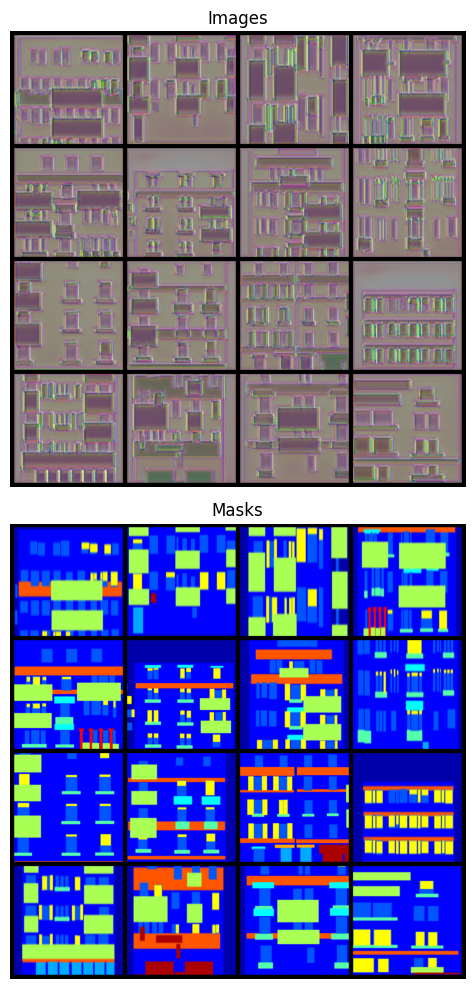

Epoch 3/24 | Validation Loss: 0.3938512921333313 | Discriminator Validation Loss: 0.14468839764595032


Epoch 4/24: 100%|████████████████████| 19/19 [00:09<00:00,  2.10it/s, Loss=37.4]


Epoch 4/24 | Generator Training Loss: 34.94734613518966 | Discriminator Training Loss: 0.07039913711579222
Epoch 4/24 | Validation Loss: 0.37763022184371947 | Discriminator Validation Loss: 0.06551807373762131


Epoch 5/24: 100%|████████████████████| 19/19 [00:08<00:00,  2.12it/s, Loss=34.2]


Epoch 5/24 | Generator Training Loss: 33.59665870666504 | Discriminator Training Loss: 0.058279308833573996
Epoch 5/24 | Validation Loss: 0.36980371475219725 | Discriminator Validation Loss: 0.10662267357110977


Epoch 6/24: 100%|████████████████████| 19/19 [00:08<00:00,  2.17it/s, Loss=27.5]


Epoch 6/24 | Generator Training Loss: 32.357215680574114 | Discriminator Training Loss: 0.08453489604749177


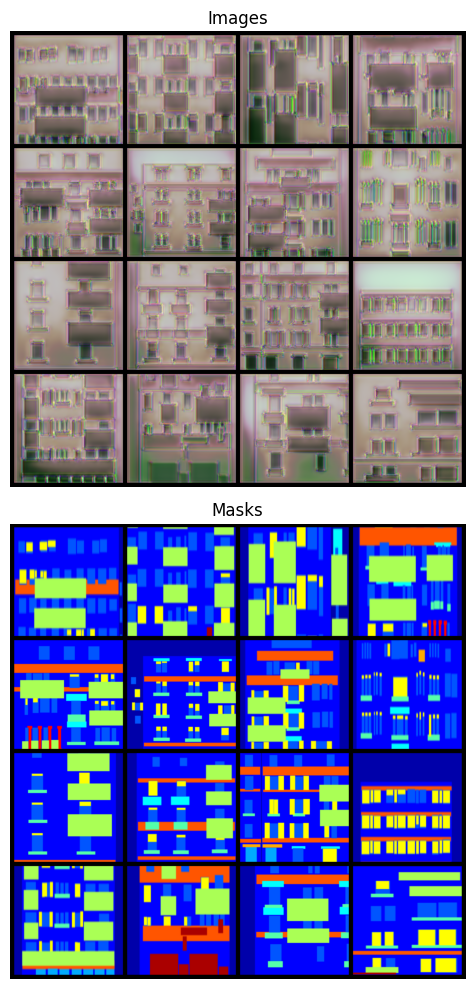

Epoch 6/24 | Validation Loss: 0.3631239354610443 | Discriminator Validation Loss: 0.2744614779949188


Epoch 7/24: 100%|████████████████████| 19/19 [00:08<00:00,  2.22it/s, Loss=28.7]


Epoch 7/24 | Generator Training Loss: 30.853993164865596 | Discriminator Training Loss: 0.06991583265756306
Epoch 7/24 | Validation Loss: 0.35826443433761596 | Discriminator Validation Loss: 0.10286624729633331


Epoch 8/24: 100%|████████████████████| 19/19 [00:08<00:00,  2.22it/s, Loss=29.8]


Epoch 8/24 | Generator Training Loss: 30.782271334999486 | Discriminator Training Loss: 0.05725780501961708
Epoch 8/24 | Validation Loss: 0.3563172936439514 | Discriminator Validation Loss: 0.09955509752035141


Epoch 9/24: 100%|██████████████████████| 19/19 [00:08<00:00,  2.18it/s, Loss=30]


Epoch 9/24 | Generator Training Loss: 30.423198699951172 | Discriminator Training Loss: 0.04637122409124123


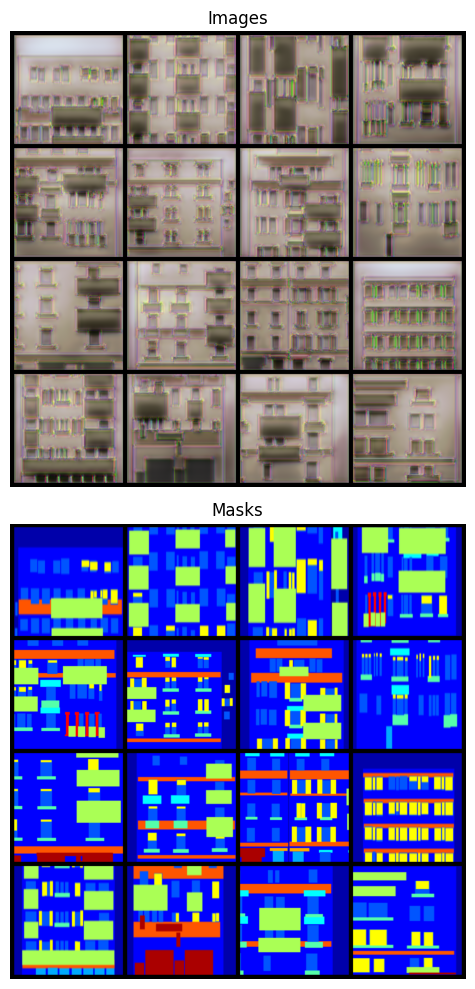

Epoch 9/24 | Validation Loss: 0.35947647094726565 | Discriminator Validation Loss: 0.0856681764125824


Epoch 10/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.19it/s, Loss=29.4]


Epoch 10/24 | Generator Training Loss: 29.652639991358708 | Discriminator Training Loss: 0.039923498407006264
Epoch 10/24 | Validation Loss: 0.36379505395889283 | Discriminator Validation Loss: 0.08087056130170822


Epoch 11/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.22it/s, Loss=30.9]


Epoch 11/24 | Generator Training Loss: 29.199915032637747 | Discriminator Training Loss: 0.04158079192826623
Epoch 11/24 | Validation Loss: 0.35499106645584105 | Discriminator Validation Loss: 0.08325940370559692


Epoch 12/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.20it/s, Loss=30.6]


Epoch 12/24 | Generator Training Loss: 29.258880414460833 | Discriminator Training Loss: 0.042218380852749475


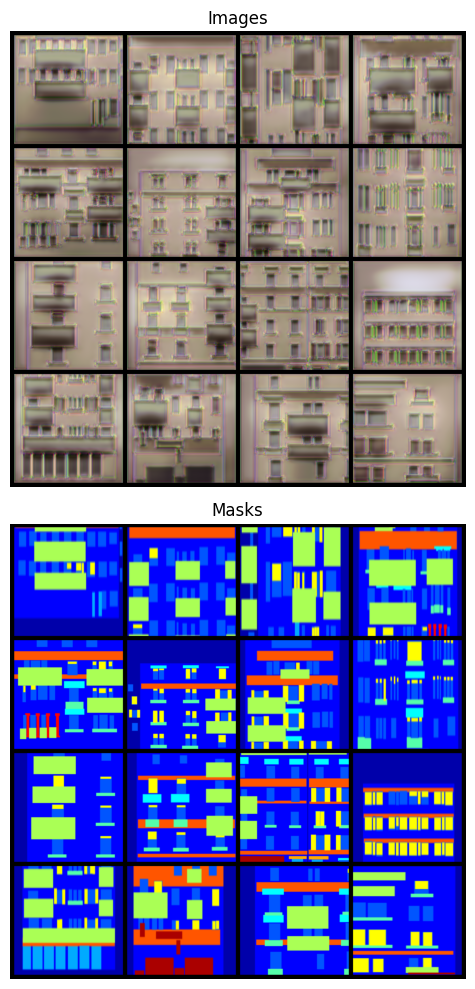

Epoch 12/24 | Validation Loss: 0.3554516136646271 | Discriminator Validation Loss: 0.06541787832975388


Epoch 13/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.23it/s, Loss=27.8]


Epoch 13/24 | Generator Training Loss: 28.594647256951582 | Discriminator Training Loss: 0.044501579611709245
Epoch 13/24 | Validation Loss: 0.3552780866622925 | Discriminator Validation Loss: 0.06249517947435379


Epoch 14/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.15it/s, Loss=34.5]


Epoch 14/24 | Generator Training Loss: 29.19403738724558 | Discriminator Training Loss: 0.03767262389393229
Epoch 14/24 | Validation Loss: 0.3527125954627991 | Discriminator Validation Loss: 0.07303877919912338


Epoch 15/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.22it/s, Loss=28.5]


Epoch 15/24 | Generator Training Loss: 28.237973564549495 | Discriminator Training Loss: 0.03694965357058927


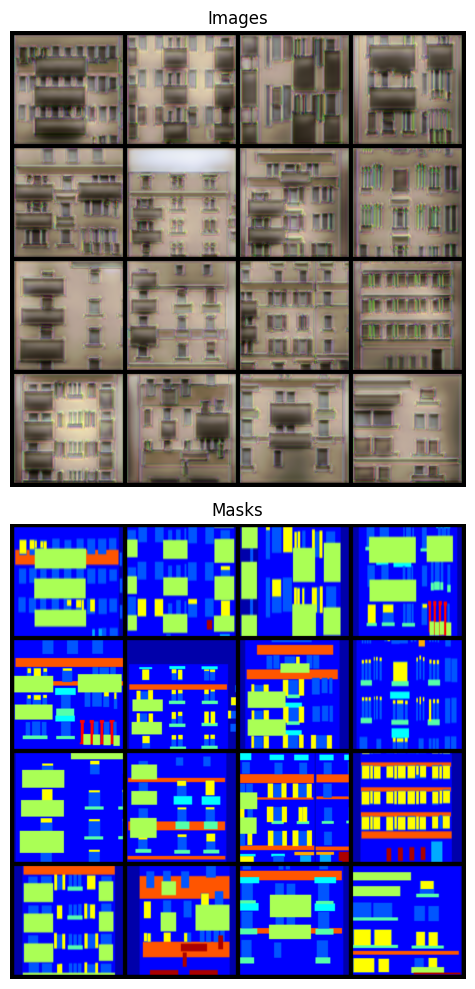

Epoch 15/24 | Validation Loss: 0.3512535631656647 | Discriminator Validation Loss: 0.05052277073264122


Epoch 16/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.20it/s, Loss=25.7]


Epoch 16/24 | Generator Training Loss: 28.072514885350277 | Discriminator Training Loss: 0.03551534298611315
Epoch 16/24 | Validation Loss: 0.362077534198761 | Discriminator Validation Loss: 0.051112402230501175


Epoch 17/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.19it/s, Loss=29.7]


Epoch 17/24 | Generator Training Loss: 28.231300855937757 | Discriminator Training Loss: 0.03208770102968341
Epoch 17/24 | Validation Loss: 0.35031924247741697 | Discriminator Validation Loss: 0.045797936618328094


Epoch 18/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.24it/s, Loss=28.4]


Epoch 18/24 | Generator Training Loss: 28.17816794546027 | Discriminator Training Loss: 0.02713281622058467


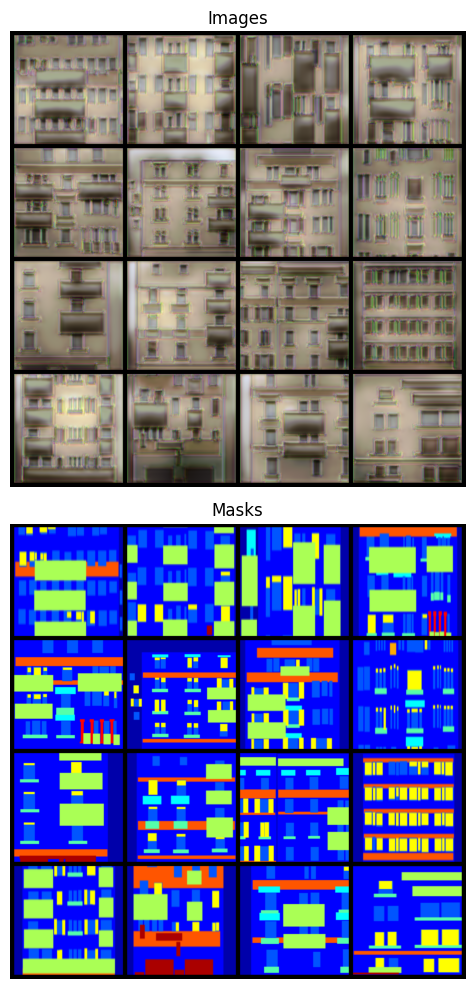

Epoch 18/24 | Validation Loss: 0.3556226909160614 | Discriminator Validation Loss: 0.048271775245666504


Epoch 19/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.19it/s, Loss=31.1]


Epoch 19/24 | Generator Training Loss: 27.786136827970807 | Discriminator Training Loss: 0.02671290090993831
Epoch 19/24 | Validation Loss: 0.3528138041496277 | Discriminator Validation Loss: 0.053006868809461594


Epoch 20/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.25it/s, Loss=28.8]


Epoch 20/24 | Generator Training Loss: 27.51472111752159 | Discriminator Training Loss: 0.030524257080335366
Epoch 20/24 | Validation Loss: 0.35455426573753357 | Discriminator Validation Loss: 0.06799838691949844


Epoch 21/24: 100%|█████████████████████| 19/19 [00:08<00:00,  2.25it/s, Loss=26]


Epoch 21/24 | Generator Training Loss: 27.278472599230316 | Discriminator Training Loss: 0.036904026803217437


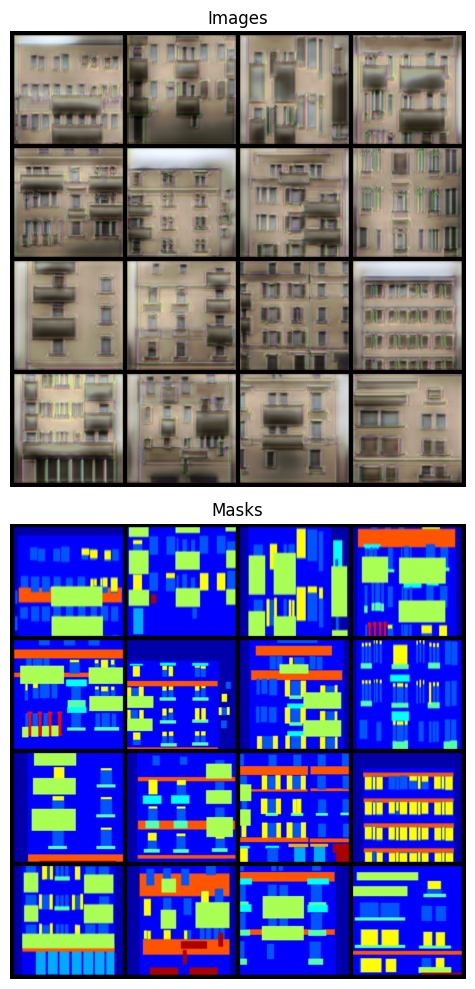

Epoch 21/24 | Validation Loss: 0.35093793272972107 | Discriminator Validation Loss: 0.05657157301902771


Epoch 22/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.29it/s, Loss=25.4]


Epoch 22/24 | Generator Training Loss: 27.21349354794151 | Discriminator Training Loss: 0.030648185332354746
Epoch 22/24 | Validation Loss: 0.3568173170089722 | Discriminator Validation Loss: 0.052291691303253174


Epoch 23/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.19it/s, Loss=27.8]


Epoch 23/24 | Generator Training Loss: 27.302662196912262 | Discriminator Training Loss: 0.026659806700129258
Epoch 23/24 | Validation Loss: 0.3649314701557159 | Discriminator Validation Loss: 0.047740787267684937


Epoch 24/24: 100%|███████████████████| 19/19 [00:08<00:00,  2.22it/s, Loss=28.4]


Epoch 24/24 | Generator Training Loss: 26.564058303833008 | Discriminator Training Loss: 0.030848751922971325


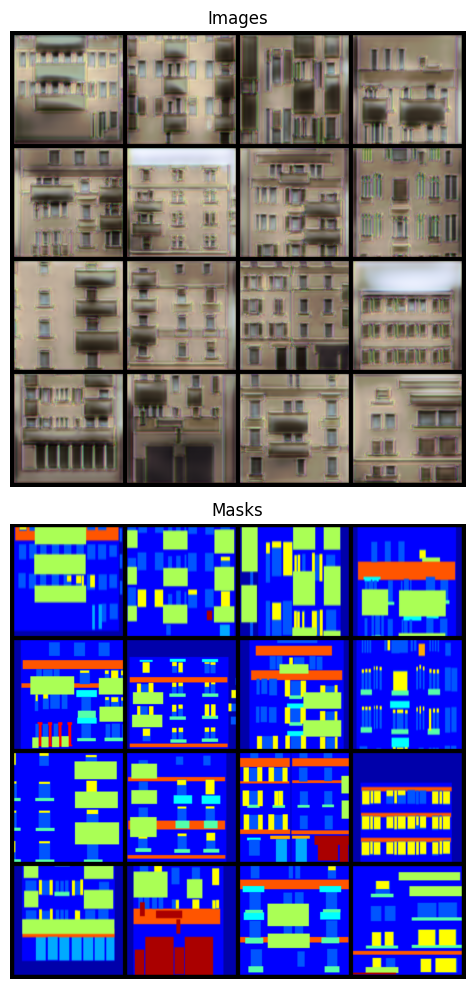

Epoch 24/24 | Validation Loss: 0.3527753949165344 | Discriminator Validation Loss: 0.043482713401317596


In [15]:
# Define the paths to your train and test data folders
train_data_path = "train_data"
test_data_path = "test_data"

# Define the transformations to be applied to the images and masks
transform_img2 = transforms.Compose(
    [
        transforms.CenterCrop(256), #Optional: Change if you are resizing the images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

transform_mask2 = transforms.Compose(
    [
        transforms.CenterCrop(256), #Optional: Change if you are resizing the images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

# Create the training dataset
train_dataset2 = CustomDataset(
    root_dir=train_data_path,
    transform=transform_img2,
    transform_mask=transform_mask2,
    flip_target_and_input=True
)

# Create the testing dataset
test_dataset2 = CustomDataset(
    root_dir=test_data_path,
    transform=transform_img2,
    transform_mask=transform_mask2,
    flip_target_and_input=True
)

# Define the batch size for the DataLoader
batch_size = 16

# Create the testing data loader
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2  = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

output_interval = 3
learning_rate = 0.0002
num_epochs = 24

random.seed(42)
torch.manual_seed(42)

# Create an instance of the UNet
gen_model = SegmentationModel(3)
dis_model = Discriminator(3)

# get output shape of image discriminator (PatchGAN)
patch = (256 // 2 ** 4, 256 // 2 ** 4) #Optional: If you changed the size of the input image you will need to change the values here

# Define loss functions
criterion = nn.L1Loss()
gan_criterion = nn.MSELoss()

# Define optimizers for generator and discriminator
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate)
dis_optimizer = optim.Adam(dis_model.parameters(), lr=learning_rate)

# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cuda:3')
gen_model.to(device)
dis_model.to(device)

# Training loop
for epoch in range(num_epochs):
    gen_train_loss = 0.0
    dis_train_loss = 0.0
    gen_val_loss = 0.0
    dis_val_loss = 0.0
    num_samples = 0

    # Set the models to training mode
    gen_model.train()
    dis_model.train()

    # Initialize the progress bar
    pbar = tqdm(train_loader2, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=80)

    for img, mask in pbar:
        # Move the data to the appropriate device
        img = img.to(device)
        mask = mask.squeeze(1).to(device)

        # Define ground truths for the GAN
        # Hint: you will need the patch variable
        valid = torch.ones((img.size(0), *patch), device=device, requires_grad=False)
        fake = torch.zeros((img.size(0), *patch), device=device, requires_grad=False)


        #### -------------- ####
        #    Generator step    #
        #### -------------- ####

        # Set generator gradients to zero
        gen_optimizer.zero_grad()

        output = gen_model(img)
        dis_output = dis_model(output, img)

        gen_loss = criterion(output, mask)
        gan_loss = gan_criterion(dis_output, valid)
        loss = gan_loss + 100 * gen_loss

        # Backward pass and optimization step
        loss.backward()
        gen_optimizer.step()

        # Update the progress bar description with the current loss
        pbar.set_postfix({"Loss": loss.item()})
        gen_train_loss += loss.item()

        #### ------------------ ####
        #    Discriminator step    #
        #### ------------------ ####

        dis_optimizer.zero_grad()

        real_pred = dis_model(mask, img)
        real_loss = gan_criterion(real_pred, valid)

        fake_pred = dis_model(output.detach(), img)
        fake_loss = gan_criterion(fake_pred, fake)


        dis_loss = 0.5 * (real_loss + fake_loss)

        dis_loss.backward()

        dis_optimizer.step()

        dis_train_loss += dis_loss.item()

    gen_train_loss /= len(train_loader2)
    dis_train_loss /= len(train_loader2)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Generator Training Loss: {gen_train_loss} | Discriminator Training Loss: {dis_train_loss}")

    # Validation loop
    # Set the models to evaluation mode
    gen_model.eval()
    dis_model.eval()

    iteration = 0  # Initialize the iteration counter
    with torch.no_grad():
        for val_img, val_mask in test_loader2:
            val_img = val_img.to(device)
            val_mask = val_mask.squeeze(1).to(device)
            val_output = gen_model(val_img)

            # Define ground truths for the GAN
            valid = torch.ones((val_img.size(0), *patch), device=device, requires_grad=False)
            fake = torch.zeros((val_img.size(0), *patch), device=device, requires_grad=False)

            # compute validation loss
            gen_val_loss += criterion(val_output, val_mask).item()
            dis_val_loss += gan_criterion(dis_model(val_mask, val_img), valid) + gan_criterion(dis_model(val_output, val_img), fake).item()

            if (epoch + 1) % output_interval == 0 and iteration == 0:
                plot_batch(val_output.cpu(), val_img.cpu())

            iteration += 1

        # update validation loss
        gen_val_loss /= len(test_loader2)
        dis_val_loss /= len(test_loader2)

        print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {gen_val_loss} | Discriminator Validation Loss: {dis_val_loss}")

***Answer Questions here***

Training the model for only 24 epochs is not enough for the model to generate fine details like stairs, roof structures and colour.